In [28]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import tensorflow as tf
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import GlobalAveragePooling2D, AveragePooling2D, Dense, Flatten, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [43]:
def train_df(tr_path):
    classes, class_paths = zip(*[(label, os.path.join(tr_path, label, image))
                                 for label in os.listdir(tr_path) if os.path.isdir(os.path.join(tr_path, label))
                                 for image in os.listdir(os.path.join(tr_path, label))])

    tr_df = pd.DataFrame({'Class Path': class_paths, 'Class': classes})
    return tr_df

def test_df(ts_path):
    classes, class_paths = zip(*[(label, os.path.join(ts_path, label, image))
                                 for label in os.listdir(ts_path) if os.path.isdir(os.path.join(ts_path, label))
                                 for image in os.listdir(os.path.join(ts_path, label))])

    ts_df = pd.DataFrame({'Class Path': class_paths, 'Class': classes})
    return ts_df

def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return float(lr * tf.math.exp(-0.1))

In [44]:
# train_path = 'brain_tumor_dataset/Training'
# test_path = 'brain_tumor_dataset/Testing'
train_path = 'brain_tumor_dataset/Training_balanced'
test_path = 'brain_tumor_dataset/Testing_balanced'

In [45]:
train_df = train_df(train_path)
test_df = test_df(test_path)
valid_df, test_df = train_test_split(test_df, train_size=0.5, random_state=20, stratify=test_df['Class'])
valid_df

,Class Path,Class
816,brain_tumor_dataset/Testing_balanced/meningiom...,meningioma
617,brain_tumor_dataset/Testing_balanced/meningiom...,meningioma
495,brain_tumor_dataset/Testing_balanced/pituitary...,pituitary
155,brain_tumor_dataset/Testing_balanced/notumor/T...,notumor
1161,brain_tumor_dataset/Testing_balanced/glioma/Te...,glioma
...,...,...
421,brain_tumor_dataset/Testing_balanced/pituitary...,pituitary
418,brain_tumor_dataset/Testing_balanced/pituitary...,pituitary
115,brain_tumor_dataset/Testing_balanced/notumor/T...,notumor
41,brain_tumor_dataset/Testing_balanced/notumor/T...,notumor


In [94]:
batch_size = 32
img_size = (224, 224)

_gen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_gen = ImageDataGenerator(rescale=1/255)


train_gen = _gen.flow_from_dataframe(train_df, x_col='Class Path',
                                  y_col='Class', batch_size=batch_size,
                                  target_size=img_size)

valid_gen = test_gen.flow_from_dataframe(valid_df, x_col='Class Path',
                                     y_col='Class', batch_size=batch_size,
                                     target_size=img_size)

test_gen = test_gen.flow_from_dataframe(test_df, x_col='Class Path',
                                  y_col='Class', batch_size=16,
                                  target_size=img_size, shuffle=False)

Found 5284 validated image filenames belonging to 4 classes.
Found 600 validated image filenames belonging to 4 classes.
Found 600 validated image filenames belonging to 4 classes.


In [95]:
print(f"Training samples: {train_gen.samples}")
print(f"Validation samples: {test_gen.samples}")
print(f"Validation samples: {valid_gen.samples}")

Training samples: 5284
Validation samples: 600
Validation samples: 600


In [96]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

checkpoint_filepath = './ckpt/checkpoint_xception2.model.keras'
model_temp = Xception(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
model_temp.trainable = False

model = Sequential()
model.add(model_temp)
model.add(AveragePooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(4, activation='softmax'))

optimizer = Adam(learning_rate=0.01)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=5, mode='min', verbose=1, restore_best_weights=True) 

lr_scheduler = LearningRateScheduler(scheduler)

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)
model.summary()

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ xception (Functional)           │ (None, 7, 7, 2048)     │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_9             │ (None, 3, 3, 2048)     │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_9 (Flatten)             │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 256)            │     4,718,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_49          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,582,380 (97.59 MB)

 Trainable params: 4,720,388 (18.01 MB)

 Non-trainable params: 20,861,992 (79.58 MB)

Num GPUs Available:  0


In [97]:
import time
start_time = time.time()

epochs = 50
history = model.fit(
    train_gen,
    epochs=epochs,
    validation_data=valid_gen,
    callbacks=[lr_scheduler, model_checkpoint_callback, early_stopping]
)

end_time = time.time()

print('The training of the Transfer Learning model took',round((end_time-start_time)/60),'minutes.')

/root/test_model/venv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 48s 273ms/step - accuracy: 0.6928 - loss: 0.9329 - val_accuracy: 0.8550 - val_loss: 0.3601 - learning_rate: 0.0100
Epoch 2/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 45s 268ms/step - accuracy: 0.8535 - loss: 0.4066 - val_accuracy: 0.8867 - val_loss: 0.2770 - learning_rate: 0.0100
Epoch 3/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 43s 256ms/step - accuracy: 0.8646 - loss: 0.3580 - val_accuracy: 0.8767 - val_loss: 0.3180 - learning_rate: 0.0100
Epoch 4/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 47s 282ms/step - accuracy: 0.8784 - loss: 0.3327 - val_accuracy: 0.8683 - val_loss: 0.3605 - learning_rate: 0.0100
Epoch 5/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 44s 265ms/step - accuracy: 0.8850 - loss: 0.3288 - val_accuracy: 0.9083 - val_loss: 0.2534 - learning_rate: 0.0100
Epoch 6/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 43s 257ms/step - accuracy: 0.8989 - loss: 0.2776 - val_accuracy: 0.8917 - val_loss: 0.2693 - learning_rate: 0.0100
Epoch 7/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 44s 261ms/step - accuracy: 0.8

In [98]:
best_model = tf.keras.models.load_model(checkpoint_filepath)
test_loss, test_accuracy = best_model.evaluate(
    test_gen,
    # steps=test_generator.samples // test_generator.batch_size
)

print(f"Test Loss: {round(test_loss,4)}")
print(f"Test Accuracy: {round(100*test_accuracy,2)}%")


38/38 ━━━━━━━━━━━━━━━━━━━━ 8s 191ms/step - accuracy: 0.9201 - loss: 0.2124
Test Loss: 0.1891
Test Accuracy: 92.83%


In [99]:
print(history.history)

{'accuracy': [0.7660862803459167, 0.8556017875671387, 0.8646858334541321, 0.875473141670227, 0.8847464323043823, 0.8934519290924072, 0.888720691204071, 0.8993186950683594, 0.8953444361686707, 0.9072672128677368, 0.9078349471092224, 0.9076457023620605, 0.9106737375259399, 0.922785758972168, 0.9188115000724792, 0.9237320423126221, 0.9322482943534851, 0.936033308506012, 0.9364117980003357, 0.9462528228759766], 'loss': [0.6505467891693115, 0.3963373899459839, 0.3667275309562683, 0.32534080743789673, 0.31681475043296814, 0.29033833742141724, 0.2977369427680969, 0.273793488740921, 0.26915016770362854, 0.24750679731369019, 0.24097846448421478, 0.2329167127609253, 0.23825706541538239, 0.2087930291891098, 0.216733917593956, 0.2067437767982483, 0.18322598934173584, 0.17456765472888947, 0.17488880455493927, 0.1559062898159027], 'val_accuracy': [0.8550000190734863, 0.8866666555404663, 0.8766666650772095, 0.8683333396911621, 0.9083333611488342, 0.8916666507720947, 0.8899999856948853, 0.920000016689

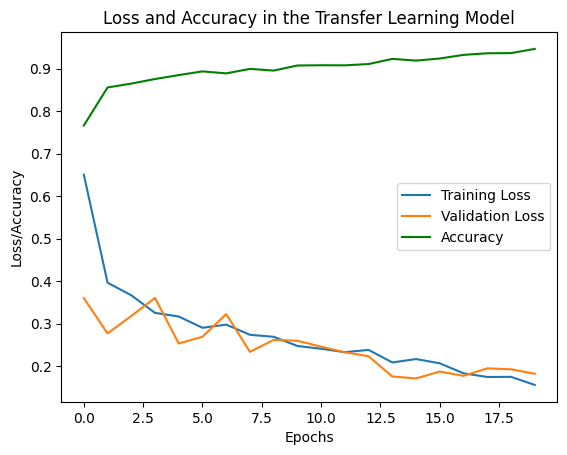

In [100]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.plot(history.history["accuracy"],label='Accuracy' ,c="green")
plt.title("Loss and Accuracy in the Transfer Learning Model")
plt.ylabel("Loss/Accuracy")
plt.xlabel("Epochs")
plt.legend()
plt.show()


In [101]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

predicted_labels = np.argmax(best_model.predict(test_gen),axis=1)

38/38 ━━━━━━━━━━━━━━━━━━━━ 8s 202ms/step


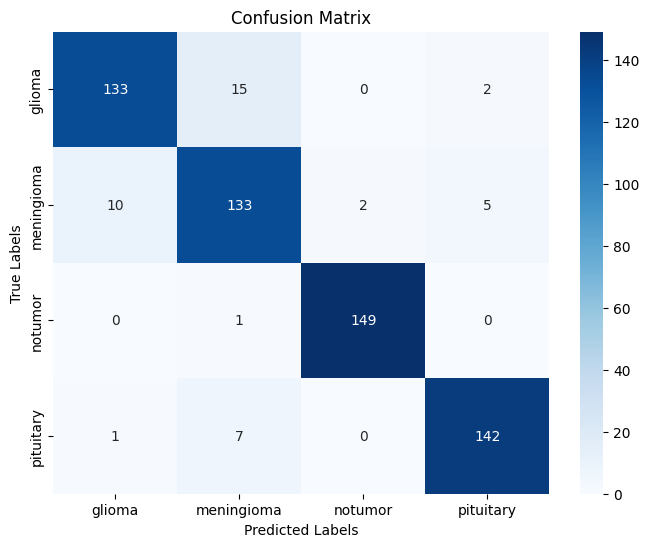

In [102]:
import seaborn as sns

true_labels = test_gen.classes

cm = confusion_matrix(true_labels, predicted_labels)

# Step 4: Plot the confusion matrix using Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_gen.class_indices.keys(), yticklabels=test_gen.class_indices.keys())
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()
